In [1]:
## Standard libraries
import os
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_1636\960354683.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Using device cpu


In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial12/"
# Files to download
pretrained_files = ["PixelCNN.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [3]:
# Convert images from 0-1 to 0-255 (integers). We use the long datatype as we will use the images as labels as well
def discretize(sample):
    return (sample * 255).to(torch.long)

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Seed set to 42


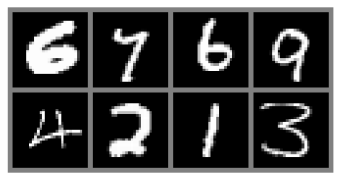

In [4]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

In [5]:
class MaskedConvolution(nn.Module):

    def __init__(self, c_in, c_out, mask, **kwargs):
        """
        Implements a convolution with mask applied on its weights.
        Inputs:
            c_in - Number of input channels
            c_out - Number of output channels
            mask - Tensor of shape [kernel_size_H, kernel_size_W] with 0s where
                   the convolution should be masked, and 1s otherwise.
            kwargs - Additional arguments for the convolution
        """
        super().__init__()
        # For simplicity: calculate padding automatically
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if "dilation" not in kwargs else kwargs["dilation"]
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)])
        # Actual convolution
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding=padding, **kwargs)

        # Mask as buffer => it is no parameter but still a tensor of the module
        # (must be moved with the devices)
        self.register_buffer('mask', mask[None,None])

    def forward(self, x):
        self.conv.weight.data *= self.mask # Ensures zero's at masked positions
        return self.conv(x)

In [6]:
class VerticalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height, but for simplicity, we stick with masking here.
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:,:] = 0

        # For the very first convolution, we will also mask the center row
        if mask_center:
            mask[kernel_size//2,:] = 0

        super().__init__(c_in, c_out, mask, **kwargs)

class HorizontalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        mask = torch.ones(1,kernel_size)
        mask[0,kernel_size//2+1:] = 0

        # For the very first convolution, we will also mask the center pixel
        if mask_center:
            mask[0,kernel_size//2] = 0

        super().__init__(c_in, c_out, mask, **kwargs)

In [7]:
class GatedMaskedConv(nn.Module):

    def __init__(self, c_in, **kwargs):
        """
        Gated Convolution block implemented the computation graph shown above.
        """
        super().__init__()
        self.conv_vert = VerticalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(2*c_in, 2*c_in, kernel_size=1, padding=0)
        self.conv_horiz_1x1 = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0)

    def forward(self, v_stack, h_stack):
        # Vertical stack (left)
        v_stack_feat = self.conv_vert(v_stack)
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)

        # Horizontal stack (right)
        h_stack_feat = self.conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_stack_out = self.conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack

        return v_stack_out, h_stack_out

In [8]:
class PixelCNN(pl.LightningModule):

    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.save_hyperparameters()

        # Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, mask_center=True)
        # Convolution block of PixelCNN. We use dilation instead of downscaling
        self.conv_layers = nn.ModuleList([
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=4),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden)
        ])
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)

        self.example_input_array = train_set[0][0][None]

    def forward(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # Scale input from 0 to 255 back to -1 to 1
        x = (x.float() / 255.0) * 2 - 1

        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))

        # Output dimensions: [Batch, Classes, Channels, Height, Width]
        out = out.reshape(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])
        return out

    def calc_likelihood(self, x):
        # Forward pass with bpd likelihood calculation
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='none')
        bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
        return bpd.mean()

    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill
                             should be -1 in the input tensor.
        """
        # Create empty image
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        # Generation loop
        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    # Skip if not to be filled (-1)
                    if (img[:,c,h,w] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    pred = self.forward(img[:,:,:h+1,:])
                    probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                    img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('test_bpd', loss)

In [9]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "PixelCNN"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=150,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
                                    LearningRateMonitor("epoch")])
    result = None
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "PixelCNN.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = PixelCNN.load_from_checkpoint(pretrained_filename)
        ckpt = torch.load(pretrained_filename, map_location=device)
        result = ckpt.get("result", None)
    else:
        model = PixelCNN(**kwargs)
        trainer.fit(model, train_loader, val_loader)
    model = model.to(device)

    if result is None:
        # Test best model on validation and test set
        val_result = trainer.test(model, val_loader, verbose=False)
        test_result = trainer.test(model, test_loader, verbose=False)
        result = {"test": test_result, "val": val_result}
    return model, result

In [10]:
model, result = train_model(c_in=1, c_hidden=64)
test_res = result["test"][0]
print("Test bits per dimension: %4.3fbpd" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_bpd"]))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\coding\python\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Found pretrained model, loading...


Lightning automatically upgraded your loaded checkpoint from v0.9.0 to v2.1.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint d:\ut_courses\RESEARCH\Qiang_Liu\Xingchao\Lehao_Project\saved_models\tutorial12\PixelCNN.ckpt`


Test bits per dimension: 0.808bpd


In [11]:
num_params = sum([np.prod(param.shape) for param in model.parameters()])
print("Number of parameters: {:,}".format(num_params))

Number of parameters: 852,160


Seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

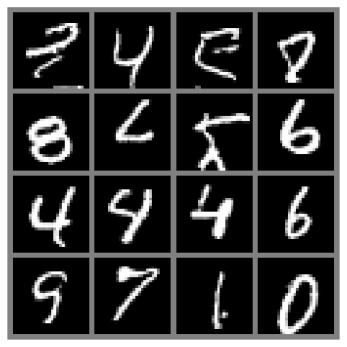

In [12]:
pl.seed_everything(1)
samples = model.sample(img_shape=(16,1,28,28))
show_imgs(samples.cpu())

Seed set to 1


  0%|          | 0/64 [00:00<?, ?it/s]

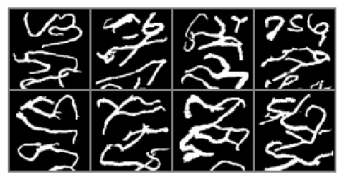

In [13]:
pl.seed_everything(1)
samples = model.sample(img_shape=(8,1,64,64))
show_imgs(samples.cpu())

In [14]:
def autocomplete_image(img):
    # Remove lower half of the image
    img_init = img.clone()
    img_init[:,10:,:] = -1
    print("Original image and input image to sampling:")
    show_imgs([img,img_init])
    # Generate 12 example completions
    img_init = img_init.unsqueeze(dim=0).expand(12,-1,-1,-1).to(device)
    pl.seed_everything(1)
    img_generated = model.sample(img_init.shape, img_init)
    print("Autocompletion samples:")
    show_imgs(img_generated)